# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

In [2]:
import skimage.io
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import closing, square
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Brain image visualization

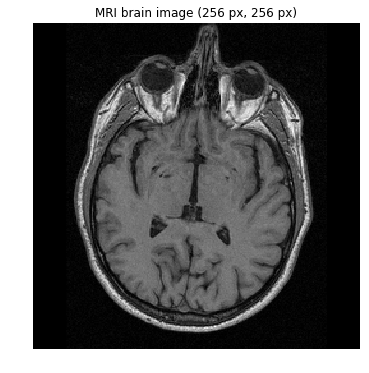

In [31]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [41]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


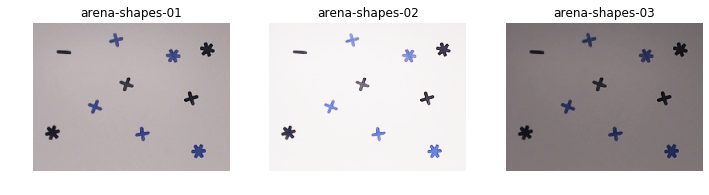

In [42]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

As first step we will try to distinguish foreground (shapes) from background. For that we will use contour based methods, namely Canny filter.

In [264]:
ind = 2 # Choose what image to process

In [265]:
image = images[ind]

In [266]:
grayscale = rgb2gray(image) * 255

In [269]:
edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection

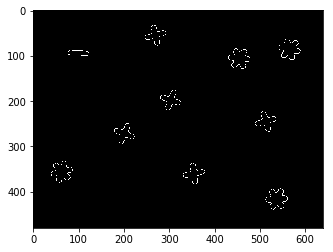

In [270]:
plt.imshow(edges, cmap="gray")
plt.show()

Great, now we have edges. Method worked relatively good, because source images have quite low level of noise.

Now we have to fill holes in shapes. For that we will use mathematical morphology methods. We will do closing with increasing size of structuring element till holes will be fully filled.

In [271]:
square_size = [5, 10, 20, 30, 40, 50]
mask_similarity_threshold = 0.999

shapes_mask = closing(edges, selem=square(square_size[0]))
for size in square_size[1:]:
    new_shapes_mask = closing(edges, selem=square(size))
    if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
        break
    shapes_mask = new_shapes_mask

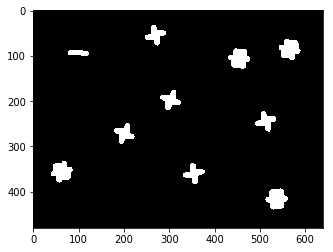

In [272]:
plt.imshow(shapes_mask, cmap="gray")
plt.show()

Now lets store pixels of each shape. For that we will use region growing method implemeneted in first part.

In [273]:
def get_neighbours(pixel):
    return [(pixel[0] + 1, pixel[1]), 
            (pixel[0] - 1, pixel[1]),
            (pixel[0], pixel[1] + 1),
            (pixel[0], pixel[1] - 1)]

In [274]:
def grow(pixel_to_start, mask, visited):
    stack = [pixel_to_start]
    region = [pixel_to_start]

    while len(stack):
        cur_pixel = stack.pop()

        pixels_to_check = get_neighbours(cur_pixel)
    
        pixels_from_region = [pixel for pixel in pixels_to_check if shapes_mask[pixel] and not visited[pixel]]
        
        # Update containers
        stack.extend(pixels_from_region)
        for pixel in pixels_from_region:
            visited[pixel] = 1
        region.extend(pixels_from_region)
        
    return region

In [275]:
def region_growing(image, mask):
    regions = []
    visited = np.zeros(mask.shape)
    
    while True: # Each iteration is aimed to process one region
        pixels_to_grow = shapes_mask * (1 - visited) # Search pixels not attached for any processed region
        
        if len(pixels_to_grow[pixels_to_grow > 0]) == 0:
            break
            
        X, Y = np.where(pixels_to_grow > 0)
        pixel_to_start = (X[0], Y[0]) # Pixel from unknown region
        
        region = grow(pixel_to_start, shapes_mask, visited)
        regions.append(region)
         
    return regions

In [276]:
%time regions = region_growing(image, shapes_mask)
print(f"{len(regions)} shapes were found")

Wall time: 97.8 ms
10 shapes were found


Now we can use all pixels from region to calculate mean value

In [277]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.21227364, 60.14285714, 88.85513078],
       [36.3867367 , 33.8325673 , 39.35325016],
       [57.68366013, 59.77320261, 89.58235294],
       [39.20081136, 36.53752535, 41.25557809],
       [53.68598131, 50.06261682, 55.01401869],
       [37.37012369, 34.26260704, 38.18839201],
       [57.94604651, 60.22418605, 90.90976744],
       [36.9324147 , 34.917979  , 40.03608924],
       [50.66993144, 53.165524  , 86.69245837],
       [48.48860759, 52.97911392, 87.5943038 ]])

We know that there are two colors: blue and gray. Gray color has relatively small std between color channels compared to blue color. Lets exploit that. 

In [278]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.01232197514604,
 2.255903926193349,
 14.569672588453344,
 1.9314698005357582,
 2.092548524840191,
 1.6910880907667276,
 15.031085282312013,
 2.1051735007949373,
 16.42459455862163,
 17.472618237145518]

In [279]:
mean_std = np.mean(region_std)
region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
region_labels

['Blue',
 'Gray',
 'Blue',
 'Gray',
 'Gray',
 'Gray',
 'Blue',
 'Gray',
 'Blue',
 'Blue']

In [280]:
print(f"Now we can say that we have {region_labels.count('Blue')} blue and {region_labels.count('Gray')} gray shapes.")

Now we can say that we have 5 blue and 5 gray shapes.


Now, let's check that we labeled shapes correctly:

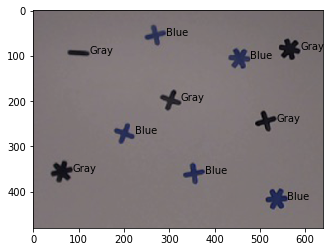

In [281]:
plt.imshow(image)
for ind in range(len(regions)):
    region_pixels = regions[ind]
    Y, X = zip(*region_pixels)
    plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
plt.show()

Oui!

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion